# An introduction to Pandas using simulated random tracks

LAG-MNG Python lecture, 26/05/2020

Francesca van Tartwijk

## 1. Introduction

Welcome to a new LAG-MNG Python notebook! This week, the topic is Pandas, a library that can help you work with large tabular datasets.

This notebook has the following sections:
- Introduction (You are Here)
- Pandas and its usefulness
- Generating an *E. coli*-inspired dataset
- The Pandas dataframe
- Data visualisation with Pandas
- Further resources
- Exercises

We will first briefly discuss what Pandas really is, and why you might want to use it. Then, we'll introduce a simple model that generates Pandas DataFrames with which we can play. We will then use these DataFrames to learn the properties of DataFrames by example, and to get some practice in data visualisation using Pandas.

## 2. Pandas and its usefulness

Pandas is a Python library for data management. As a library, it can be imported and then used in any interpreter that has the corresponding module installed. Notably, it has several 'dependencies', including NumPy (it relies on NumPy functionalities to work), so you must also have installed NumPy if you want to use Pandas. Like NumPy, it can be used to work with datasets, but rather than working with arrays, it works with tabular data.

Pandas DataFrames are a bit like tables, and therefore may remind you of Excel spreadsheets, but they can be used in ways Excel cannot! Each column is a labelled array of values, and so you can use Numpy vectorised operations to very quickly access only the values in which you are interested (and then perform operations on them). It deals well with missing data values, as well as with time series data and non-homogenous arrays. The library also has a range of plotting functions that you can apply to DataFrames.

## 3. Generating an *E. coli*-inspired dataset

A tracking dataset is good example of a type of dataset that has a large number of entries and may be outputted in a tabular format. Here, will we use a model that generates tracks and also returns some parameters describing features of those tracks. The model is inspired by a real biological system.

A very famous example of a motile biological entity is *Escherichia coli*, which moves towards certain molecules (attractants) and away from others (repellents) in a process known as chemotaxis. (The signalling pathway underpinning chemotactic behaviour has been carefully studied, as well as how it affects the flagellar motors that drive locomotion; see 'Further resources' at the end of this document if you'd like to learn more.) However, rather than moving directly up an attractant gradient (or down a repellent gradient), the cell executes a so-called 'biased random walk'. 

In the context of chemotaxis, biased random walks are a form of motion in which net displacement of the cell occurs in a favourable direction, even though the orientation of each segment of the track is random. *E. coli* movement is characterised by 'runs' and 'tumbles'. When all flagella are bundled together, the cell moves smoothly forward, but when they disperse, it is no longer propelled in one direction. Due to its small size (small particle Reynolds number), the cell rapidly comes to a stop when propulsion ceases. It then reorients randomly under Brownian motion, until the flagella bundle up again, at which point it again moves forward in whatever direction it happened to be oriented. In the presence of higher attractant concentrations, tumbles are suppressed, which leads to net movement up the attractant gradient. However, due to the adaptation inherent to the chemotaxis signalling pathways, tumbles are not completely suppressed (this contributes to the system's large dynamic range). The following diagram illustrates this type of movement:

<img src="biasedrandom.png" />

The code below generates a large number of biased random walks in the presence of an attractant, in two dimensions. Run length here depends on three variables: time since the last tumble (to give some form of adaptation), attractant concentration, and a random number generator (to reflect some of the stochasticity of switching behaviour). It is not intended to represent the biochemical or biophysical basis of the chemotactic behaviour of *E. coli*, nor indeed to truly recapitulate that behaviour. Instead, its purpose is primarily to give you a fun (biology-inspired) and rapidly constructable dataset with which to learn Pandas! You don't need to understand every line below in order to continue to the next section. 

In [54]:
'''
This code generates a dataset of biased random walks that is stored in Pandas DataFrames.
'''

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd


# Constants
START_TIME = 0.0 #do not modify
END_TIME = 20.0 #duration of tracking 'experiment'
TIME_INCREMENT = 0.1 #time step size
STEP_NUMBER = int(END_TIME/TIME_INCREMENT) #do not modify

WORLD_SIZE_X = 10.0 #world width 
WORLD_SIZE_Y = 10.0 #world height

START_POSITION_RANDOM = True #toggle whether start position is random
START_POSITION = (5.0, 5.0) #start position if not random (set to centre of world, may be modified)

TOTAL_SPEED = 1.2 #assumed to be constant property of bacterium in given environment

TUMBLE_THRESHOLD = 0.6 #threshold used by reorientation function; higher threshold makes reorientation less likely

REPEAT_NUMBER = 1000 #number of tracks to be obtained


# Helper functions
def test_out_of_bounds(x, y, velocity_x, velocity_y):
    '''
    Test whether the cell has reached the walls of the world and reset velocity components to make cell bounce off 
    wall if appropriate. Collisions are assumed to be perfectly elastic with the wall infinitely heavy.
    '''
    if x >= WORLD_SIZE_X or x <= 0:
        velocity_x = -velocity_x
    if y >= WORLD_SIZE_Y or y <= 0:
        velocity_y = -velocity_y
    return (velocity_x, velocity_y)

def attractant_distribution(x, y):
    '''
    Describes the distribution of an attractant. This can be modified by the user.
    Note the function should not have zero values within the range of coordinates included in the world.
    '''
    #attractant_concentration = 0.15*x**2 - 0.15*y**2 + 0.1
    attractant_concentration = 1 + 5*x
    return attractant_concentration

def set_speed():
    '''
    Sets x- and y-components of the velocity to random values.
    The vector magnitude (TOTAL_SPEED) is kept constant.
    '''
    velocity_x = random.uniform(-TOTAL_SPEED, TOTAL_SPEED) #randomise x-component of velocity
    velocity_y = (TOTAL_SPEED**2 - velocity_x**2) #use formula for vector magnitude
    random_orientation_y = random.uniform(-1,1) #magnitude of velocity_y is fixed when velocity_x is fixed, but not sign
    if random_orientation_y >= 0.0: #use random number to determine sign of y-component
        velocity_y = -velocity_y
    return (velocity_x, velocity_y)

def set_start_position():
    '''
    Generate a random start position for each track
    '''
    x = random.uniform(0.0,10.0)
    y = random.uniform(0.0,10.0)
    return (x,y)

def update_position(x, y, velocity_x, velocity_y):
    '''
    Update the position of the cell with each time step.
    '''
    x = x + velocity_x * TIME_INCREMENT
    y = y + velocity_y * TIME_INCREMENT
    return (x, y)

def reorientation(time, time_last_tumble, x, y):
    '''
    Determines whether the cell should reorient at a given time (returns a Boolean).
    Reorientation probability depends on the time since last tumble and the attractant concentration.
    A random component is added using a random number generator (motor switching is partly stochastic).
    '''
    attractant_concentration = attractant_distribution(x, y)
    
    time_since_last_tumble = time - time_last_tumble
    random_number = random.uniform(0.0,5.0)
    time_dependent_random_number = time_since_last_tumble * random_number
    
    return (time_dependent_random_number / attractant_concentration) > TUMBLE_THRESHOLD

def get_track():
    '''
    Generates a random track using the specified constants. 
    A random start position may be chosen, or this may be specified as a constant
    '''
    cell_location_x = np.zeros(STEP_NUMBER) #set up empty array to store track x-coordinates
    cell_location_y = np.zeros(STEP_NUMBER) #set up empty array to store track y-coordinates
    run_length = [] #set up empty list in which to store run lengths (in units of time)
    
    time = START_TIME
    time_last_tumble = START_TIME
    (velocity_x, velocity_y) = set_speed()
    
    if START_POSITION_RANDOM:
        start_position = set_start_position()
        (x,y) = start_position
    else:
        (x,y) = START_POSITION
    
    for i in range(STEP_NUMBER):
        (velocity_x, velocity_y) = test_out_of_bounds(x,y, velocity_x, velocity_y)
        (x, y) = update_position(x, y, velocity_x, velocity_y)
        cell_location_x[i] = x
        cell_location_y[i] = y
        time = time + TIME_INCREMENT
        if reorientation(time, time_last_tumble, x, y):
            (velocity_x, velocity_y) = set_speed()
            run_length.append(time-time_last_tumble)
            time_last_tumble = time
    end_position = (x,y)
            
    return cell_location_x, cell_location_y, run_length, start_position, end_position


#main function (obtain database for multiple tracks)
'''
Generates and stores a number (REPEAT_NUMBER) of random tracks produced by get_track().
Results are stored in lists. Associated track numbers are stored in separate lists.
'''
run_length_database = [] #create empty lists that will become dataframe columns
run_length_track_numbers_database = []
x_coordinate_database = []
y_coordinate_database = []
coordinate_track_numbers_database = []
x_displacement_database = []
y_displacement_database = []
displacement_track_numbers_database = []

for i in range(REPEAT_NUMBER):
    (cell_location_x, cell_location_y, run_length, start_position, end_position) = get_track()
    
    run_length_database.extend(run_length) #add new values to future columns
    x_coordinate_database.extend(cell_location_x)
    y_coordinate_database.extend(cell_location_y)
    x_displacement_database.append(end_position[0]-start_position[0])
    y_displacement_database.append(end_position[1]-start_position[1])
    
    run_length_track_number = [i]*len(run_length) #generate lists of track numbers to associate with values in columns
    run_length_track_numbers_database.extend(run_length_track_number)
    coordinate_track_number = [i]*len(cell_location_x)
    coordinate_track_numbers_database.extend(coordinate_track_number)
    displacement_track_numbers_database.append(i)

    
#dataframe creation
'''
Stores the track coordinates and relevant parameters in Pandas dataframes.
'''
df_coordinates = pd.DataFrame([coordinate_track_numbers_database, x_coordinate_database, y_coordinate_database])
df_coordinates = df_coordinates.transpose()
df_coordinates.columns = ['track_number_coordinate','x_coordinate', 'y_coordinate']

df_run_lengths = pd.DataFrame([run_length_track_numbers_database, run_length_database])
df_run_lengths = df_run_lengths.transpose()
df_run_lengths.columns = ['track_number_run', 'run_length']

df_displacements = pd.DataFrame([displacement_track_numbers_database, x_displacement_database, y_displacement_database])
df_displacements = df_displacements.transpose()
df_displacements.columns = ['track_number_displacement', 'x_displacement', 'y_displacement']

We can plot the last of the resulting tracks to visualise the output of ```get_track()```, before we start exploring the whole dataset:

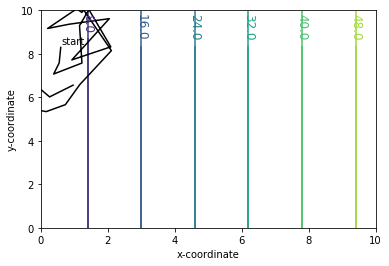

In [58]:
#plotting the output of get_track()
'''
Plots a random track using arrays of coordinates returned by get_track().
Labels the track start point.
Plots the attractant distribution as a contour plot. 
(Warning: the contour plotting will produce an error for a constant attractant concentration,)
'''
plt.plot(cell_location_x.T, cell_location_y.T, 'k') #take transpose of arrays to associate coordinates appropriately
axes = plt.gca()
axes.set_xlim([0.0,10.0])
axes.set_ylim([0.0,10.0])
axes.set_xlabel('x-coordinate')
axes.set_ylabel('y-coordinate')

plt.annotate('start', start_position) #annotate the track start position

xa, ya = np.meshgrid(np.arange(0.0,10.0,0.05), np.arange(0.0,10.0,0.05))
plt.contour(xa, ya, attractant_distribution(xa, ya)) 
CS = axes.contour(xa, ya, attractant_distribution(xa,ya))
axes.clabel(CS, inline=1, fontsize=12, fmt='%1.1f')

#plt.savefig('track.pdf')
plt.show()

## 4. The Pandas DataFrame

The code above stored the outputs for each track into three different DataFrames (df_coordinates, df_runlengths, and df_displacements). As mentioned previously, these are table-like objects (in particular Python terminology, they are a instances of a class object type), with columns and rows. Columns have headings, and rows have indices, which enable you to access them in an intuitive way. Let's have a quick look at the df_coordinates DataFrame to explore what this looks like when displayed:

In [59]:
print(df_coordinates.head()) # You can print the first or last five rows of the dataframe to check its structure using .head()
df_coordinates.tail(3) #passing in an argument determines the number of rows displayed

   track_number_coordinate  x_coordinate  y_coordinate
0                      0.0      2.717695      1.329136
1                      0.0      2.830259      1.311843
2                      0.0      2.942823      1.294550
3                      0.0      3.055387      1.277256
4                      0.0      3.167951      1.259963


,track_number_coordinate,x_coordinate,y_coordinate
199997,999.0,0.787237,6.423998
199998,999.0,0.874808,6.491312
199999,999.0,0.962378,6.558626


### 4.1 Accessing and manipulating DataFrame structure and values 

The indices and column headings allow you to access parts of the DataFrame. This is a form of slicing. For instance, you could access different parts of the ```df_coordinates``` DataFrames in some of these ways:

In [ ]:
print(df_coordinates['x_coordinate']) #access by column name
print(df_coordinates[2:4]) #access by row index
print(df_coordinates.loc[2:4, ['x_coordinate', 'y_coordinate']]) #by index and column names; N.B .loc is end-inclusive

You can also filter on column value or name, e.g.:

In [112]:
df_coordinates[df_coordinates['x_coordinate'] > 7.5]

,track_number_coordinate,x_coordinate,y_coordinate
43,0.0,7.557949,0.585523
44,0.0,7.670513,0.568230
45,0.0,7.783077,0.550937
46,0.0,7.895642,0.533644
47,0.0,8.008206,0.516350
...,...,...,...
199795,998.0,8.954520,2.830610
199796,998.0,8.983976,2.695287
199797,998.0,9.013433,2.559964
199798,998.0,9.042890,2.424641


It is possible to quickly access overall column properties as well:

In [62]:
print(df_displacements['x_displacement'].describe())
print(df_displacements['y_displacement'].describe())

count    1000.000000
mean        1.115270
std         3.671013
min        -9.496631
25%        -1.309327
50%         1.188412
75%         3.599850
max         9.485344
Name: x_displacement, dtype: float64
count    1000.000000
mean       -0.049176
std         4.161444
min        -9.796638
25%        -3.132651
50%        -0.024471
75%         2.856045
max         9.731128
Name: y_displacement, dtype: float64


If you want to access a specific property of the column, this can be achieved in a similar way:

In [63]:
df_displacements['x_displacement'].mean()

1.115270304507787

You can manipulate the DataFrame in a range of ways. For instance, you may want to reorder, add, or remove columns, or reassign specific values. We won't do this for this specific dataset, but these are some relevant functions:
```python
    df.rename(columns = {'oldname':'newname'}, inplace=True)
    df.loc[index,['columnname']] = values
    df.loc[:, 'columnname'] = np.array([5]*len(df)) #would replace all values in the column with 5
    df.['name for new column'] = values #may be combination of other column values
```

Pandas also has a lot of in-built functions that can help you manipulate DataFrames. For instance, you can also sort dataframes by the values in specific columns, which may also be insightful. This uses ```.groupby()```. As an additional example: if we wanted to merge all columns into one DataFrame, the function ```.concat()``` can do this work for us. We can specify the way in which the columns should be 'glued together' (see the Pandas documentation):

In [32]:
df_total = pd.concat([df_coordinates, df_displacements, df_run_lengths], axis=1)
df_total.head()

,track_number_coordinate,x_coordinate,y_coordinate,track_number_displacement,x_displacement,y_displacement,track_number_run,run_length
0,0.0,6.749012,5.516289,0.0,-0.564498,1.720419,0.0,5.9
1,0.0,6.860721,5.497076,1.0,3.099605,-4.293645,0.0,6.6
2,0.0,6.972429,5.477864,2.0,4.757247,-6.385991,0.0,5.0
3,0.0,7.084137,5.458652,3.0,3.142418,-0.197495,1.0,5.9
4,0.0,7.195846,5.439439,4.0,4.242554,-1.646336,1.0,5.1


### 4.2 Creating dataframes from other Python objects

In the code above that generated the dataset, values were stored in lists that were then converted into columns in a DataFrame.
    
```python
    df_coordinates = pd.DataFrame([coordinate_track_numbers_database, x_coordinate_database, y_coordinate_database])
    df_coordinates = df_coordinates.transpose()
    df_coordinates.columns = ['track_number_coordinate','x_coordinate', 'y_coordinate']
```

Here, the function ```pd.DataFrame``` takes a list of lists as its argument, and stores the values into a new DataFrame. Since these lists are taken as rows, we transpose to get the DataFrame we actually want. We then assign all of the columns a header, by which we can subsequently refer to them.

The ```pd.DataFrame``` function accepts several object types as arguments, not just lists: an ndarray (structured or homogeneous), Iterable, dictionary, or DataFrame. The dictionaries can consist of Series, arrays, constants, or list-like objects. As a result, the object is described as 'two-dimensional, size-mutable, potentially heterogeneous tabular data'. There are specific functions to construct DataFrames out of lists of tuples (```DataFrame.from_records```) and dictionaries (```DataFrame.from_dict```).

### 4.3 Interconverting between (saved) files in your directory and DataFrames

Pandas DataFrames exist in memory (like for instance NumPy arrays), but you can save them to a directory in a range of file formats (text, csv, or xslx):

In [258]:
df_coordinates.to_csv('coordinates.csv', index=False) #saves the DataFrame df_coordinates to a csv named coordinates.csv

Similarly, you can read in a range of file types to construct a Pandas DataFrame:

In [260]:
df_newcoordinates = pd.read_csv('coordinates.csv') #reads a csv file coordinates.csv and places the values in a DataFrame
df_newcoordinates.head()

,track_number_coordinate,x_coordinate,y_coordinate
0,0.0,5.270482,6.702521
1,0.0,5.379175,6.728379
2,0.0,5.487869,6.754237
3,0.0,5.596562,6.780095
4,0.0,5.705255,6.805952


## 5. Data visualisation with Pandas

Just as you can easily determine the mean or other properties for a given DataFrame column, you can also readily plot the values it stores! This uses ```matplotlib.pyplot``` functions that you may already know as attributes, and is a quick and handy way of visualising your data. There is a range of plots you can use, some of which will be showcased here.

Pandas also has some plotting functions that take entire dataframes or series (rather than columns) as input. These include autocorrelation plots and scatter matrices, as well as other types of plots. These can be imported from ```pandas.plotting```. We will not these functions here, but they can can all be found in the visualisation section of the Pandas documentation.

### 5.1 Quick plots using columns of a single DataFrame

It is straightforward to plot all values in a given DataFrame column. Let's start with the DataFrames for $attractant(x, y) = 1 + 5*x$ that we just generated.

We may want to visualise the distribution of all datapoints in two-dimensions, such as for ```df_coordinates```. It is very easy to make a scatterplot with Pandas. You apply the method ```.plot.scatter()``` to the DataFrame object (note you use the column names to set x and y), and then all that's left for you to do is to label and format the plot:

Text(0.5, 1.0, 'Density of tracks (N=1000, attractant = 1 + 5x)')

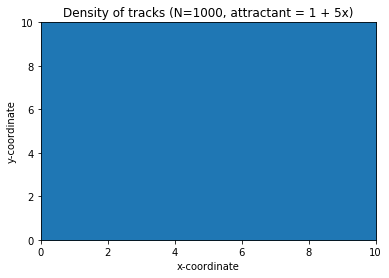

In [22]:
axes = df_coordinates.plot.scatter(x='x_coordinate', y='y_coordinate', sharex = False) #sharex should be False by default
axes.set_xlim([0.0,10.0])
axes.set_ylim([0.0,10.0])
axes.set_xlabel('x-coordinate')
axes.set_ylabel('y-coordinate')
axes.set_title('Density of tracks (N=1000, attractant = 1 + 5x)')

For our dataset, this looks entirely full, since we have a lot of datapoints, and so is not very informative... Therefore, it is more sensible for us to plot the density of points. Pandas allows you to easily do this for two-dimensional data, using a type of plot known as a hexaplot:

Text(0.5, 1.0, 'Density of tracks (N=1000, attractant = 1 + 5x)')

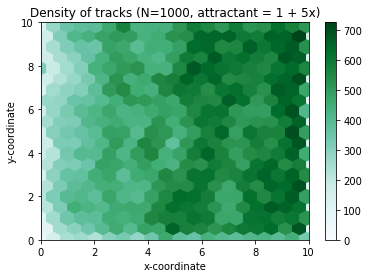

In [57]:
axes = df_coordinates.plot.hexbin(x='x_coordinate', y='y_coordinate',gridsize=20, sharex = False) #sharex should be False by default
axes.set_xlim([0.0,10.0])
axes.set_ylim([0.0,10.0])
axes.set_xlabel('x-coordinate')
axes.set_ylabel('y-coordinate')
axes.set_title('Density of tracks (N=1000, attractant = 1 + 5x)')
#plt.savefig('hexaplot.pdf')

We may also want to plot some of the results of our analysis (in this case, the displacements and run lengths that our model has helpfully already returned for us). Pandas allows you to plot columns as histograms, bar charts, line plots, box plots, et cetera. As an example, this is how you would plot a histogram of the net displacement in the x-direction (note you specify which column you want to access using the column header):

Text(0.5, 1.0, 'Histogram of end-to-end distance in x-direction (N=1000, attractant = 1+5x)')

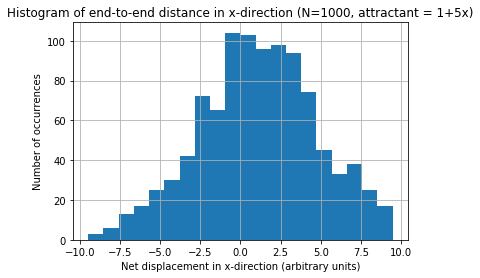

In [55]:
ax = df_displacements['x_displacement'].hist(bins=20)
ax.set_xlabel('Net displacement in x-direction (arbitrary units)')
ax.set_ylabel('Number of occurrences')
ax.set_title('Histogram of end-to-end distance in x-direction (N=1000, attractant = 1+5x)')

We can also do this for two different columns at once, which is conveniently achieved if the dataframe has an internal dictionary structure:

Text(0.5, 1.0, 'Net displacement in x and y (N=1000, attractant = 1+5x)')

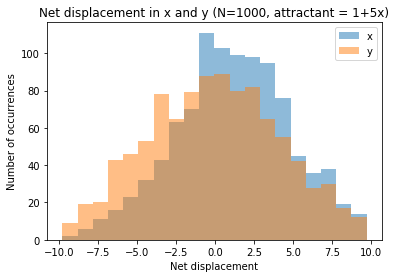

In [56]:
df_dict = pd.DataFrame({'x': df_displacements['x_displacement'], 'y': df_displacements['y_displacement']}, columns=['x', 'y'])
ax = df_dict.plot.hist(bins=20, alpha=0.5) #alpha sets the opacity of the bars
ax.set_xlabel('Net displacement')
ax.set_ylabel('Number of occurrences')
ax.set_title('Net displacement in x and y (N=1000, attractant = 1+5x)')
#plt.savefig('histogram.pdf')

### 5.2 Comparing different DataFrames

You may have acquired multiple datasets that correspond to different conditions, which you have read in as different DataFrames from different files. In this final subsection, we'll explore how to visualise data from such different DataFrames in one plot. 

Let's start by loading several csv files that contain a thousand random tracks for different (constant) attractant levels:

In [80]:
df_one = pd.read_csv('attractantisone.csv')
df_five = pd.read_csv('attractantisfive.csv')
df_ten = pd.read_csv('attractantisten.csv')

We would expect the run length to be different for these, at least in this model, and may want to compare those values. You could in principle create a new DataFrame using columns from these ones, but this is not necessary. Instead, you can plot all in the same figure in an iterative manner:

Text(0.5, 1.0, 'Comparison of run length at different attractant concentrations')

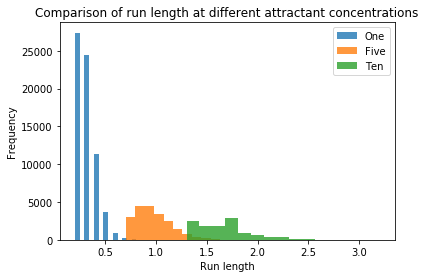

In [105]:
fig = plt.figure()

for frame in [df_one, df_five, df_ten]:
    frame['run_length'].plot.hist(bins=15, alpha=0.8)
plt.legend(['One','Five','Ten'])
axes = plt.gca()
axes.set_xlabel('Run length')
axes.set_title('Comparison of run length at different attractant concentrations')

Note this way of plotting really shows the effect of the time step size in our simple model!

## 6. Further resources

This notebook is not intended as a complete overview of Pandas. Instead, it should have given you enough understanding of the library to go forth and discover the other functions it has to offer! Most of these you will be able to find by googling a question you have, but you can also search the Pandas documentation directly.

The Pandas documentation can be found here: https://pandas.pydata.org/pandas-docs/stable/index.html

If you'd like to revise some of the concepts from this notebook, these Youtube videos could help you get you started:
- A short introduction to basic DataFrame manipulation: https://www.youtube.com/watch?v=e60ItwlZTKM
- An hour-long introduction to Pandas: https://www.youtube.com/watch?v=vmEHCJofslg (you can watch this at increased playback speed)

If you'd like to learn more about chemotaxis, this may be of interest: https://www.cell.com/current-biology/comments/S0960-9822(02)01424-0 (Webre et al., 2003, *Current Biology*)

## 7. Exercises

1. Derive the ```df_displacement``` values from the ```df_coordinates``` values.
2. Visit the visualisation section of the Pandas documentation (https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html). Using the provided dataset, generate one of the plot types not showcased in the notebook. If you like, you can modify the constants or the attractant concentration function to change the cell's behaviour in any way you find interesting to create your own dataset.
3. Return to the statistics notebook, and compare two different columns in a quantitative way. 
4. Load one of your own tabular datasets into a Pandas DataFrame, and make an interesting plot!